# Training Notebook

Train the CatMeowCNN model on preprocessed data.


In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path("..").resolve()))
sys.path.insert(0, str(Path("../src").resolve()))

from src.data_loader import load_train_data, load_test_data, get_train_val_loaders, get_test_loader
from src.train import train, cross_validate
from src.test import test
from src.transforms import SpecAugment, Compose, RandomApply, AddNoise
from models import CatMeowCNN, TransferCNN
import matplotlib.pyplot as plt
import torch


import pickle

RESULTS_DIR = Path("../results")

## 1. Load Data


In [2]:
DATA_DIR = Path("../data/interim")
MODEL_PATH = Path("../results/cat_meow.pt")

# Ensure results dir exists
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

# Load train and test separately
X_train, y_train = load_train_data(DATA_DIR)
X_test, y_test = load_test_data(DATA_DIR)

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")
print(f"Classes: {len(set(y_train))}")


Train: X=(80, 128, 173), y=(80,)
Test:  X=(20, 128, 173), y=(20,)
Classes: 10


In [3]:
# Augmentation for training
train_transform = Compose([
    SpecAugment(freq_mask_param=15, time_mask_param=25),
    RandomApply(AddNoise(noise_level=0.005), p=0.3),
])

# Split training data into train/val
train_loader, val_loader = get_train_val_loaders(
    X_train, y_train, batch_size=16, train_transform=train_transform
)
print(f"Train: {len(train_loader.dataset)} samples (with augmentation)")
print(f"Val: {len(val_loader.dataset)} samples")
print(f"Test: {len(X_test)} samples (held out)")


Train: 64 samples (with augmentation)
Val: 16 samples
Test: 20 samples (held out)


## 2. Create Model


In [4]:
n_classes = len(set(y_train))
model = CatMeowCNN(n_classes=n_classes)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model: CatMeowCNN")
print(f"Parameters: {n_params:,}")


Model: CatMeowCNN
Parameters: 422,986


## 3. Train


In [ ]:
# Train a final model and evaluate on test set
model = CatMeowCNN(n_classes=n_classes)

# Get fresh loaders
train_loader, val_loader = get_train_val_loaders(
    X_train, y_train, batch_size=16, train_transform=train_transform
)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    learning_rate=0.001,
    save_path=str(MODEL_PATH),
    patience=40,
)


## 5. Evaluate


In [ ]:
# Load best model and evaluate on held-out test data
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
test_loader = get_test_loader(X_test, y_test)
results = test(model, test_loader)


## 6. Cross-Validation

Run k-fold cross-validation for a more reliable accuracy estimate with limited data.


In [ ]:
# Run 5-fold cross-validation on training data
cv_results = cross_validate(
    model_class=CatMeowCNN,
    X=X_train,
    y=y_train,
    n_splits=5,
    epochs=100,
    learning_rate=0.001,
    batch_size=16,
    patience=40,
    n_classes=n_classes,  # passed to CatMeowCNN
)


In [ ]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(8, 4))
folds = [r["fold"] for r in cv_results["fold_results"]]
accs = cv_results["accuracies"]

ax.bar(folds, accs, color='steelblue', edgecolor='white')
ax.axhline(cv_results["mean_acc"], color='red', linestyle='--', 
           label=f'Mean: {cv_results["mean_acc"]:.3f} ± {cv_results["std_acc"]:.3f}')
ax.set_xlabel("Fold")
ax.set_ylabel("Validation Accuracy")
ax.set_title("5-Fold Cross-Validation Results")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nCV Accuracy: {cv_results['mean_acc']:.1%} ± {cv_results['std_acc']:.1%}")


In [ ]:
# Plot training curves for each fold
n_folds = len(cv_results["fold_results"])
fig, axes = plt.subplots(n_folds, 2, figsize=(12, 3 * n_folds))

for i, fold_result in enumerate(cv_results["fold_results"]):
    fold_history = fold_result["history"]
    fold_num = fold_result["fold"]
    
    # Loss
    axes[i, 0].plot(fold_history["train_loss"], label="Train")
    axes[i, 0].plot(fold_history["val_loss"], label="Val")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].set_title(f"Fold {fold_num} - Loss")
    axes[i, 0].legend()
    
    # Accuracy
    axes[i, 1].plot(fold_history["train_acc"], label="Train")
    axes[i, 1].plot(fold_history["val_acc"], label="Val")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].set_title(f"Fold {fold_num} - Accuracy (Best: {fold_result['best_val_acc']:.3f})")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


## 8. Save Results for Diagnostics


In [ ]:
# Save all training results for diagnostics notebook
import pickle

RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Bundle all results
training_results = {
    "history": history,
    "cv_results": cv_results,
    "test_results": results,
    "n_classes": n_classes,
}

with open(RESULTS_DIR / "training_results.pkl", "wb") as f:
    pickle.dump(training_results, f)

print(f"Saved training results to {RESULTS_DIR / 'training_results.pkl'}")
print(f"  - Training history: {len(history['train_loss'])} epochs")
print(f"  - CV results: {len(cv_results['fold_results'])} folds")
print(f"  - Test accuracy: {results['accuracy']:.1%}")


## 9. Model Comparison: CNN vs Transfer Learning

Compare our simple CatMeowCNN with transfer learning using pretrained ResNet.


In [ ]:
from models import TransferCNN

# Define models to compare
models_to_compare = {
    "CatMeowCNN": lambda: CatMeowCNN(n_classes=n_classes),
    "TransferCNN (frozen)": lambda: TransferCNN(n_classes=n_classes, backbone="resnet18", freeze_backbone=True),
    "TransferCNN (fine-tune)": lambda: TransferCNN(n_classes=n_classes, backbone="resnet18", freeze_backbone=False),
}

# Show model sizes
print("Model Comparison:")
print("-" * 50)
for name, model_fn in models_to_compare.items():
    m = model_fn()
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    print(f"{name:25} | Total: {total:>10,} | Trainable: {trainable:>10,}")


In [ ]:
# Run cross-validation for each model
comparison_results = {}

for name, model_fn in models_to_compare.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    # Use lower learning rate for transfer learning
    lr = 0.0001 if "Transfer" in name else 0.001
    
    cv_result = cross_validate(
        model_class=model_fn,  # Pass the lambda function
        X=X_train,
        y=y_train,
        n_splits=5,
        epochs=50,  # Fewer epochs for comparison
        learning_rate=lr,
        batch_size=16,
        patience=15,
        n_classes=n_classes,
        verbose=False,  # Less output
    )
    
    comparison_results[name] = cv_result
    print(f"\n✓ {name}: {cv_result['mean_acc']:.1%} ± {cv_result['std_acc']:.1%}")


In [ ]:
# Visualize comparison results
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(comparison_results.keys())
means = [comparison_results[name]["mean_acc"] for name in model_names]
stds = [comparison_results[name]["std_acc"] for name in model_names]

x = np.arange(len(model_names))
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(x, means, yerr=stds, capsize=10, color=colors, 
              edgecolor='white', linewidth=2, error_kw={'linewidth': 2})

ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("CV Accuracy", fontsize=12)
ax.set_title("Model Comparison (5-Fold Cross-Validation)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.set_ylim(0, 1)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.03,
            f'{mean:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for name in model_names:
    r = comparison_results[name]
    print(f"{name:25} | {r['mean_acc']:.1%} ± {r['std_acc']:.1%}")
print("="*60)

# Find best model
best_model = max(comparison_results.keys(), key=lambda k: comparison_results[k]['mean_acc'])
print(f"\n🏆 Best Model: {best_model}")


### Train Best Model on Full Data


In [ ]:
# Train the best model on full training data
BEST_MODEL_PATH = Path("../results/best_model.pt")

# Use TransferCNN with frozen backbone (usually best for small data)
best_model = TransferCNN(n_classes=n_classes, backbone="resnet18", freeze_backbone=True)

# Get fresh loaders
train_loader, val_loader = get_train_val_loaders(
    X_train, y_train, batch_size=16, train_transform=train_transform
)

print(f"Training best model: TransferCNN (frozen ResNet18)")
print(f"Trainable params: {sum(p.numel() for p in best_model.parameters() if p.requires_grad):,}")

best_history = train(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    learning_rate=0.0001,  # Lower LR for transfer learning
    save_path=str(BEST_MODEL_PATH),
    patience=20,
)


In [ ]:
# Evaluate best model on test set
best_model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
test_loader = get_test_loader(X_test, y_test)
best_results = test(best_model, test_loader)

print("\n" + "="*50)
print("FINAL COMPARISON")
print("="*50)
print(f"CatMeowCNN Test Accuracy:    {results['accuracy']:.1%}")
print(f"TransferCNN Test Accuracy:   {best_results['accuracy']:.1%}")
print(f"Improvement:                 {(best_results['accuracy'] - results['accuracy'])*100:+.1f} percentage points")
print("="*50)


## 10. Hyperparameter Optimization (Bayesian)

Using Optuna with TPE sampler to find optimal hyperparameters.

TPE: https://arxiv.org/abs/2304.11127


In [5]:
import optuna
from optuna.samplers import TPESampler

# Suppress Optuna logs (optional)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """Objective function for Optuna optimization."""
    
    # Hyperparameters to tune
    model_type = trial.suggest_categorical("model", ["CatMeowCNN", "TransferCNN"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16])
    
    # Optimizer and regularization
    optimizer_type = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.3, 0.7)
    
    # Model-specific params
    if model_type == "TransferCNN":
        freeze = trial.suggest_categorical("freeze_backbone", [True, False])
        backbone = trial.suggest_categorical("backbone", ["resnet18", "resnet34"])
        model_fn = lambda: TransferCNN(
            n_classes=n_classes, 
            backbone=backbone, 
            freeze_backbone=freeze,
            dropout=dropout
        )
    else:
        model_fn = lambda: CatMeowCNN(n_classes=n_classes, dropout=dropout)
    
    # Quick 3-fold CV (faster than 5-fold for tuning)
    try:
        cv_result = cross_validate(
            model_class=model_fn,
            X=X_train,
            y=y_train,
            n_splits=3,
            epochs=100,  # Full training
            learning_rate=lr,
            batch_size=batch_size,
            patience=30,  # More patience for convergence
            n_classes=n_classes,
            verbose=False,
            optimizer_type=optimizer_type,
            weight_decay=weight_decay,
        )
        return cv_result["mean_acc"]
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0

print("Objective function defined. Ready to optimize!")
print("Search space: model, lr, batch_size, optimizer, weight_decay, dropout")


Objective function defined. Ready to optimize!
Search space: model, lr, batch_size, optimizer, weight_decay, dropout


/Users/bugrasipahioglu/repo/cat-sound-classifier/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Run Bayesian optimization

N_TRIALS = 50  # Reduce for faster testing, increase for better results

print(f"Starting Bayesian Optimization with {N_TRIALS} trials...")

study = optuna.create_study(
    direction="maximize",  # Maximize accuracy
    sampler=TPESampler(seed=42),
    study_name="cat_mood_classifier"
)

study.optimize(
    objective, 
    n_trials=N_TRIALS, 
    show_progress_bar=True,
    callbacks=[lambda study, trial: print(f"  Trial {trial.number}: {trial.value:.1%} | {trial.params}")]
)

print("\n" + "="*60)
print("🎉 OPTIMIZATION COMPLETE!")
print("="*60)


Starting Bayesian Optimization with 50 trials...


Best trial: 0. Best value: 0.688034:   2%|▏         | 1/50 [01:36<1:18:38, 96.29s/it]

  Trial 0: 68.8% | {'model': 'TransferCNN', 'lr': 0.001570297088405539, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0029154431891537554, 'dropout': 0.5404460046972835, 'freeze_backbone': True, 'backbone': 'resnet18'}


Best trial: 0. Best value: 0.688034:   4%|▍         | 2/50 [04:30<1:53:47, 142.23s/it]

  Trial 1: 52.6% | {'model': 'CatMeowCNN', 'lr': 3.5498788321965036e-05, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0002801635158716259, 'dropout': 0.3557975442608167}
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/bugrasipahioglu/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:47<00:00, 1.83MB/s]
Best trial: 0. Best value: 0.688034:   6%|▌         | 3/50 [10:20<3:05:30, 236.81s/it]

  Trial 2: 60.1% | {'model': 'TransferCNN', 'lr': 0.00023345864076016249, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 1.5339162591163623e-06, 'dropout': 0.5430179407605753, 'freeze_backbone': True, 'backbone': 'resnet34'}


Best trial: 0. Best value: 0.688034:   8%|▊         | 4/50 [11:16<2:07:05, 165.78s/it]

  Trial 3: 15.1% | {'model': 'CatMeowCNN', 'lr': 1.9634341572933338e-05, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 1.3726318898045876e-06, 'dropout': 0.6637281608315128}


Best trial: 0. Best value: 0.688034:  10%|█         | 5/50 [13:28<1:55:00, 153.36s/it]

  Trial 4: 18.7% | {'model': 'TransferCNN', 'lr': 8.612579192594876e-05, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0.001260466458564947, 'dropout': 0.6757995766256756, 'freeze_backbone': True, 'backbone': 'resnet18'}


Best trial: 5. Best value: 0.70038:  12%|█▏        | 6/50 [16:01<1:52:29, 153.39s/it] 

  Trial 5: 70.0% | {'model': 'CatMeowCNN', 'lr': 9.46217535646148e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 1.329652145729951e-05, 'dropout': 0.5170784332632994}


Best trial: 6. Best value: 0.737892:  14%|█▍        | 7/50 [25:09<3:22:19, 282.32s/it]

  Trial 6: 73.8% | {'model': 'TransferCNN', 'lr': 1.6736010167825783e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0018274508859816032, 'dropout': 0.5827429375390468, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 6. Best value: 0.737892:  16%|█▌        | 8/50 [30:06<3:20:56, 287.07s/it]

  Trial 7: 63.9% | {'model': 'TransferCNN', 'lr': 0.0007411299781083245, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 0.000828752236376816, 'dropout': 0.5550229885420852, 'freeze_backbone': True, 'backbone': 'resnet34'}


Best trial: 6. Best value: 0.737892:  18%|█▊        | 9/50 [33:03<2:52:33, 252.51s/it]

  Trial 8: 62.5% | {'model': 'CatMeowCNN', 'lr': 0.002055424552015075, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 2.7012557725439094e-06, 'dropout': 0.3125716742746937}


Best trial: 6. Best value: 0.737892:  20%|██        | 10/50 [35:04<2:21:23, 212.09s/it]

  Trial 9: 48.6% | {'model': 'CatMeowCNN', 'lr': 0.0003355151022721483, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 8.22607494622104e-06, 'dropout': 0.33079196393151716}


Best trial: 6. Best value: 0.737892:  22%|██▏       | 11/50 [48:40<4:18:00, 396.93s/it]

  Trial 10: 67.5% | {'model': 'TransferCNN', 'lr': 1.0422971466648474e-05, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.008456188693324764, 'dropout': 0.4375470176452059, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 6. Best value: 0.737892:  24%|██▍       | 12/50 [50:46<3:19:09, 314.46s/it]

  Trial 11: 54.9% | {'model': 'CatMeowCNN', 'lr': 0.007989048278665888, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 3.785376549158334e-05, 'dropout': 0.44930302230300745}


Best trial: 6. Best value: 0.737892:  26%|██▌       | 13/50 [53:48<2:49:05, 274.21s/it]

  Trial 12: 66.3% | {'model': 'CatMeowCNN', 'lr': 7.363420402725967e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 4.023493389405071e-05, 'dropout': 0.6043917256018407}


Best trial: 13. Best value: 0.762583:  28%|██▊       | 14/50 [1:01:15<3:15:54, 326.52s/it]

  Trial 13: 76.3% | {'model': 'TransferCNN', 'lr': 5.2774461737451415e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.00014403910932208474, 'dropout': 0.46914953388502983, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 14. Best value: 0.775404:  30%|███       | 15/50 [1:09:17<3:37:43, 373.24s/it]

  Trial 14: 77.5% | {'model': 'TransferCNN', 'lr': 2.933265535966018e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0002152328794593413, 'dropout': 0.4468899669580648, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 15. Best value: 0.80057:  32%|███▏      | 16/50 [1:17:21<3:50:22, 406.56s/it] 

  Trial 15: 80.1% | {'model': 'TransferCNN', 'lr': 4.374345244799975e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0002036095196837803, 'dropout': 0.4434333667869352, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 16. Best value: 0.850427:  34%|███▍      | 17/50 [1:23:55<3:41:39, 403.02s/it]

  Trial 16: 85.0% | {'model': 'TransferCNN', 'lr': 0.00018913347110298764, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0003403165762209692, 'dropout': 0.40685818070548724, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 16. Best value: 0.850427:  36%|███▌      | 18/50 [1:30:27<3:33:10, 399.69s/it]

  Trial 17: 85.0% | {'model': 'TransferCNN', 'lr': 0.0002461065185079347, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0004134453776765465, 'dropout': 0.39043617534284447, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 18. Best value: 0.876068:  38%|███▊      | 19/50 [1:35:27<3:10:54, 369.51s/it]

  Trial 18: 87.6% | {'model': 'TransferCNN', 'lr': 0.00021748707852479736, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0006827104714766453, 'dropout': 0.37438252969802266, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  40%|████      | 20/50 [1:39:28<2:45:30, 331.02s/it]

  Trial 19: 80.0% | {'model': 'TransferCNN', 'lr': 0.0005207999164707455, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.005120006183160024, 'dropout': 0.39070187804659856, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  42%|████▏     | 21/50 [1:43:02<2:22:58, 295.82s/it]

  Trial 20: 81.3% | {'model': 'TransferCNN', 'lr': 0.0001635238678515057, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 6.254056940699448e-05, 'dropout': 0.3829469363482016, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  44%|████▍     | 22/50 [1:47:55<2:17:38, 294.96s/it]

  Trial 21: 81.2% | {'model': 'TransferCNN', 'lr': 0.00017008314108141117, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0007321124166667314, 'dropout': 0.3868627659241011, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  46%|████▌     | 23/50 [1:56:01<2:38:31, 352.30s/it]

  Trial 22: 76.4% | {'model': 'TransferCNN', 'lr': 0.0006571340646858928, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0005196108900741271, 'dropout': 0.4088405365138157, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 18. Best value: 0.876068:  48%|████▊     | 24/50 [1:59:27<2:13:39, 308.44s/it]

  Trial 23: 80.0% | {'model': 'TransferCNN', 'lr': 0.0003235542092245492, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.00042103341894695446, 'dropout': 0.3569973021752036, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  50%|█████     | 25/50 [2:08:23<2:37:00, 376.81s/it]

  Trial 24: 87.6% | {'model': 'TransferCNN', 'lr': 0.0001437017830042879, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 9.264004106773326e-05, 'dropout': 0.48692873185608176, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 18. Best value: 0.876068:  52%|█████▏    | 26/50 [2:11:57<2:11:07, 327.80s/it]

  Trial 25: 78.9% | {'model': 'TransferCNN', 'lr': 0.00011635602022116637, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 9.417899107821864e-05, 'dropout': 0.47858578157926895, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  54%|█████▍    | 27/50 [2:21:36<2:34:32, 403.17s/it]

  Trial 26: 81.3% | {'model': 'TransferCNN', 'lr': 0.0013171133143615346, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 2.1576885749190287e-05, 'dropout': 0.4924001216599188, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 18. Best value: 0.876068:  56%|█████▌    | 28/50 [2:31:40<2:50:00, 463.66s/it]

  Trial 27: 51.2% | {'model': 'TransferCNN', 'lr': 0.004485118738212009, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.00011828594031500046, 'dropout': 0.42280744498765277, 'freeze_backbone': False, 'backbone': 'resnet34'}


Best trial: 18. Best value: 0.876068:  58%|█████▊    | 29/50 [2:34:56<2:14:05, 383.14s/it]

  Trial 28: 81.3% | {'model': 'TransferCNN', 'lr': 0.0004600824568248075, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.002408193124340478, 'dropout': 0.30010484492188505, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  60%|██████    | 30/50 [2:38:07<1:48:30, 325.52s/it]

  Trial 29: 68.9% | {'model': 'TransferCNN', 'lr': 0.0014783254910397474, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.004149099934758178, 'dropout': 0.3565992142264561, 'freeze_backbone': True, 'backbone': 'resnet34'}


Best trial: 18. Best value: 0.876068:  62%|██████▏   | 31/50 [2:43:27<1:42:37, 324.10s/it]

  Trial 30: 85.1% | {'model': 'TransferCNN', 'lr': 0.00013075729079564663, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0011992941180635785, 'dropout': 0.5101857169888976, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  64%|██████▍   | 32/50 [2:47:48<1:31:33, 305.18s/it]

  Trial 31: 85.0% | {'model': 'TransferCNN', 'lr': 0.00014499756897280624, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0008650203386346777, 'dropout': 0.4952513501807318, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  66%|██████▌   | 33/50 [2:51:45<1:20:39, 284.65s/it]

  Trial 32: 83.8% | {'model': 'TransferCNN', 'lr': 0.00019735383635878162, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.00026731355452604453, 'dropout': 0.5181231130610833, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  68%|██████▊   | 34/50 [2:58:23<1:24:57, 318.58s/it]

  Trial 33: 83.9% | {'model': 'TransferCNN', 'lr': 6.09356606585262e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.002600312864454529, 'dropout': 0.5625805985629576, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  70%|███████   | 35/50 [3:03:14<1:17:34, 310.28s/it]

  Trial 34: 86.3% | {'model': 'TransferCNN', 'lr': 0.00011917029906018493, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0016374310265486833, 'dropout': 0.6146243079558281, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  72%|███████▏  | 36/50 [3:11:04<1:23:35, 358.23s/it]

  Trial 35: 77.5% | {'model': 'TransferCNN', 'lr': 0.00011011848997678478, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 0.0014445269067818603, 'dropout': 0.6248060499474775, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  74%|███████▍  | 37/50 [3:16:41<1:16:13, 351.77s/it]

  Trial 36: 73.8% | {'model': 'TransferCNN', 'lr': 3.689356610926747e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.009058145012856783, 'dropout': 0.6393022477986537, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  76%|███████▌  | 38/50 [3:19:06<57:59, 289.97s/it]  

  Trial 37: 20.0% | {'model': 'CatMeowCNN', 'lr': 8.312336843080944e-05, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0.0012854519752966255, 'dropout': 0.6972954745546021}


Best trial: 18. Best value: 0.876068:  78%|███████▊  | 39/50 [3:21:08<43:55, 239.57s/it]

  Trial 38: 65.1% | {'model': 'TransferCNN', 'lr': 0.0002782154273233252, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0031931141522690016, 'dropout': 0.5350077922104355, 'freeze_backbone': True, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  80%|████████  | 40/50 [3:28:08<48:55, 293.52s/it]

  Trial 39: 77.5% | {'model': 'TransferCNN', 'lr': 2.229239543362451e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0006449078325836886, 'dropout': 0.5860714579193617, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  82%|████████▏ | 41/50 [3:30:16<36:36, 244.00s/it]

  Trial 40: 45.1% | {'model': 'CatMeowCNN', 'lr': 0.0008302872201368467, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 6.599564235615218e-05, 'dropout': 0.6629469056949011}


Best trial: 18. Best value: 0.876068:  84%|████████▍ | 42/50 [3:34:29<32:53, 246.68s/it]

  Trial 41: 85.1% | {'model': 'TransferCNN', 'lr': 0.00012491424085854847, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.00034387198620765096, 'dropout': 0.5228482324465047, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  86%|████████▌ | 43/50 [3:38:13<27:57, 239.68s/it]

  Trial 42: 83.9% | {'model': 'TransferCNN', 'lr': 0.00011616287721701878, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0015084971245924565, 'dropout': 0.5197759474825681, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  88%|████████▊ | 44/50 [3:40:19<20:34, 205.71s/it]

  Trial 43: 68.9% | {'model': 'TransferCNN', 'lr': 0.000453793191274615, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0009877770981144608, 'dropout': 0.5540762875860906, 'freeze_backbone': True, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  90%|█████████ | 45/50 [3:44:58<18:59, 227.81s/it]

  Trial 44: 83.8% | {'model': 'TransferCNN', 'lr': 6.619091885637704e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.00015267209176256352, 'dropout': 0.5785102905642251, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  92%|█████████▏| 46/50 [3:48:59<15:26, 231.58s/it]

  Trial 45: 82.6% | {'model': 'TransferCNN', 'lr': 0.00014440562938556324, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0006018007429339378, 'dropout': 0.4678604633646364, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  94%|█████████▍| 47/50 [3:51:18<10:11, 203.85s/it]

  Trial 46: 72.6% | {'model': 'CatMeowCNN', 'lr': 0.00034946955506001573, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0019802199177359385, 'dropout': 0.5333000702470193}


Best trial: 18. Best value: 0.876068:  96%|█████████▌| 48/50 [3:54:28<06:39, 199.74s/it]

  Trial 47: 65.0% | {'model': 'TransferCNN', 'lr': 9.736128513214338e-05, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.005527511096123011, 'dropout': 0.6005051181212525, 'freeze_backbone': True, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068:  98%|█████████▊| 49/50 [4:02:14<04:39, 279.63s/it]

  Trial 48: 58.7% | {'model': 'TransferCNN', 'lr': 5.0852608959907165e-05, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 5.982924706284625e-06, 'dropout': 0.33721492621760396, 'freeze_backbone': False, 'backbone': 'resnet18'}


Best trial: 18. Best value: 0.876068: 100%|██████████| 50/50 [4:06:19<00:00, 295.60s/it]

  Trial 49: 86.3% | {'model': 'TransferCNN', 'lr': 0.00026807984098277393, 'batch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0002533354438709343, 'dropout': 0.507254785317943, 'freeze_backbone': False, 'backbone': 'resnet18'}

🎉 OPTIMIZATION COMPLETE!


In [7]:
# Display best results
print(f"Best CV Accuracy: {study.best_value:.1%}")
print(f"\nBest Hyperparameters:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

# Show top 5 trials
print("\nTop 5 Trials:")
print("-" * 60)
trials_df = study.trials_dataframe().sort_values("value", ascending=False).head(5)
for i, row in trials_df.iterrows():
    print(f"  {row['value']:.1%} | model={row.get('params_model', 'N/A')}, lr={row.get('params_lr', 0):.2e}, batch={row.get('params_batch_size', 'N/A')}")


Best CV Accuracy: 87.6%

Best Hyperparameters:
  model: TransferCNN
  lr: 0.00021748707852479736
  batch_size: 16
  optimizer: adam
  weight_decay: 0.0006827104714766453
  dropout: 0.37438252969802266
  freeze_backbone: False
  backbone: resnet18

Top 5 Trials:
------------------------------------------------------------
  87.6% | model=TransferCNN, lr=2.17e-04, batch=16
  87.6% | model=TransferCNN, lr=1.44e-04, batch=8
  86.3% | model=TransferCNN, lr=2.68e-04, batch=16
  86.3% | model=TransferCNN, lr=1.19e-04, batch=8
  85.1% | model=TransferCNN, lr=1.25e-04, batch=8


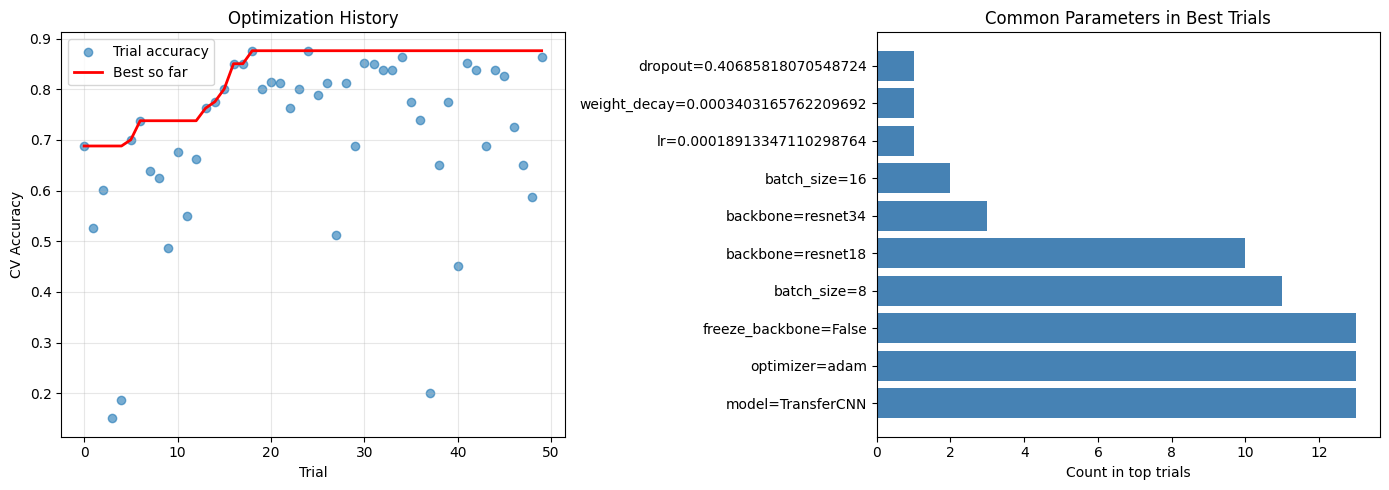

In [8]:
# Visualize optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Optimization history
trials = [t.number for t in study.trials]
values = [t.value for t in study.trials]
best_so_far = [max(values[:i+1]) for i in range(len(values))]

axes[0].scatter(trials, values, alpha=0.6, label="Trial accuracy")
axes[0].plot(trials, best_so_far, 'r-', linewidth=2, label="Best so far")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("CV Accuracy")
axes[0].set_title("Optimization History")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Parameter importance (simplified)
param_counts = {}
for t in study.trials:
    if t.value >= study.best_value * 0.95:  # Top 5% trials
        for k, v in t.params.items():
            key = f"{k}={v}"
            param_counts[key] = param_counts.get(key, 0) + 1

if param_counts:
    sorted_params = sorted(param_counts.items(), key=lambda x: -x[1])[:10]
    params, counts = zip(*sorted_params)
    axes[1].barh(range(len(params)), counts, color='steelblue')
    axes[1].set_yticks(range(len(params)))
    axes[1].set_yticklabels(params)
    axes[1].set_xlabel("Count in top trials")
    axes[1].set_title("Common Parameters in Best Trials")

plt.tight_layout()
plt.show()


### Train Final Model with Best Hyperparameters


In [13]:
# Train final model with best hyperparameters
TUNED_MODEL_PATH = Path("../results/tuned_model.pt")

best = study.best_params
print(f"Training final model with best params:")
for k, v in best.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.6f}")
    else:
        print(f"  {k}: {v}")

# Create model based on best params
if best["model"] == "TransferCNN":
    final_model = TransferCNN(
        n_classes=n_classes, 
        backbone=best.get("backbone", "resnet18"),
        freeze_backbone=best.get("freeze_backbone", True),
        dropout=best.get("dropout", 0.5)
    )
else:
    final_model = CatMeowCNN(n_classes=n_classes, dropout=best.get("dropout", 0.5))

trainable = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
print(f"\nModel: {best['model']}")
print(f"Trainable params: {trainable:,}")

# Get fresh loaders with best batch size
train_loader, val_loader = get_train_val_loaders(
    X_train, y_train, 
    batch_size=best["batch_size"], 
    train_transform=train_transform
)

# Train with more epochs now, using best optimizer and regularization
tuned_history = train(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    learning_rate=best["lr"],
    save_path=str(TUNED_MODEL_PATH),
    patience=30,  # Match tuning patience
    optimizer_type=best.get("optimizer", "adam"),
    weight_decay=best.get("weight_decay", 0.0),
)

Training final model with best params:
  model: TransferCNN
  lr: 0.000217
  batch_size: 16
  optimizer: adam
  weight_decay: 0.000683
  dropout: 0.374383
  freeze_backbone: False
  backbone: resnet18

Model: TransferCNN
Trainable params: 11,310,410
Epoch   1/100 | Train: 2.3905, 0.094 | Val: 2.2988, 0.125
  -> Saved (val_acc: 0.125)
Epoch   2/100 | Train: 2.1293, 0.297 | Val: 2.0872, 0.375
  -> Saved (val_acc: 0.375)
Epoch   3/100 | Train: 1.8671, 0.516 | Val: 1.8590, 0.375
Epoch   4/100 | Train: 1.6977, 0.672 | Val: 1.5797, 0.500
  -> Saved (val_acc: 0.500)
Epoch   5/100 | Train: 1.4623, 0.703 | Val: 1.3793, 0.562
  -> Saved (val_acc: 0.562)
Epoch   6/100 | Train: 1.2043, 0.812 | Val: 1.2556, 0.562
Epoch   7/100 | Train: 0.9846, 0.859 | Val: 1.1899, 0.562
Epoch   8/100 | Train: 0.9160, 0.797 | Val: 1.0427, 0.688
  -> Saved (val_acc: 0.688)
Epoch   9/100 | Train: 0.6588, 0.891 | Val: 0.9695, 0.750
  -> Saved (val_acc: 0.750)
Epoch  10/100 | Train: 0.5154, 0.953 | Val: 0.9354, 0.625
Ep

In [14]:
# Final evaluation on test set
final_model.load_state_dict(torch.load(TUNED_MODEL_PATH, weights_only=True))
test_loader = get_test_loader(X_test, y_test)
tuned_results = test(final_model, test_loader)

print("\n" + "="*60)
print("🏆 FINAL RESULTS")
print("="*60)
print(f"Best CV Accuracy (during tuning): {study.best_value:.1%}")
print(f"Test Accuracy (tuned model):      {tuned_results['accuracy']:.1%}")
print(f"Test Loss:                        {tuned_results['loss']:.4f}")
print("="*60)
print(f"\nBest hyperparameters saved. Model saved to: {TUNED_MODEL_PATH}")


Test Loss: 0.4181
Test Accuracy: 0.800

🏆 FINAL RESULTS
Best CV Accuracy (during tuning): 87.6%
Test Accuracy (tuned model):      80.0%
Test Loss:                        0.4181

Best hyperparameters saved. Model saved to: ../results/tuned_model.pt


In [15]:
# Save tuning results for diagnostics notebook
tuning_results = {
    "tuned_history": tuned_history,
    "tuned_results": tuned_results,
    "best_params": study.best_params,
    "best_cv_acc": study.best_value,
    "n_classes": n_classes,
    "optimization_history": [
        {"trial": t.number, "value": t.value, "params": t.params}
        for t in study.trials if t.value is not None
    ],
}

with open(RESULTS_DIR / "tuning_results.pkl", "wb") as f:
    pickle.dump(tuning_results, f)

print(f"Saved tuning results to {RESULTS_DIR / 'tuning_results.pkl'}")
print(f"  - Training history: {len(tuned_history['train_loss'])} epochs")
print(f"  - Best CV accuracy: {study.best_value:.1%}")
print(f"  - Test accuracy: {tuned_results['accuracy']:.1%}")


Saved tuning results to ../results/tuning_results.pkl
  - Training history: 58 epochs
  - Best CV accuracy: 87.6%
  - Test accuracy: 80.0%
